# 写真の減色

画像データは1600万色程度の色彩を表現できるが、これは一般的な写真の画素数よりも多い。つまり、全く使っていない色はたくさんある。また、次の写真のように、カラー写真とはいっても、実際に使っている色はそれほど多くないように見えるものもある。

![](https://live.staticflickr.com/8380/8640855620_102dda223f_z_d.jpg)

(CC BY 2.0 2009 SteFou! via Flickr)

この写真を、できるだけ少ない色数で表示してみよう。

## 白黒の場合

まず、この画像を入手し、色彩を落として、numpy arrayの形にする。414 x 640W pixelの画像なので、サイズ(414,640)の実数のarrayの各要素がそれぞれの画素の明るさを表す。


In [139]:
from imageio import imread
import PIL

img = imread("https://live.staticflickr.com/8380/8640855620_102dda223f_z_d.jpg")
img.shape

(414, 640, 3)

画像の画素ごとのデータは、通常はR(赤),G(緑),B(青)それぞれ0〜255の256段階で表現される。3色を平均して白黒画像にする。

In [ ]:
# RGB方向の平均をとり、255で割る。
import numpy as np

#平均値は実数になってしまうので、8ビット負号なし整数(0〜255)に変換しておく。
gray = np.average(img, axis=2).astype(np.uint8)
gray.shape

In [ ]:
gray

In [ ]:
# displayはJupyterの機能。
display(PIL.Image.fromarray(gray))

ヒストグラムを作る。

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
Y,X = np.histogram(gray, bins=32)
plt.plot(X[:-1],Y)

ピクセルの明るさが、100〜220に集中しているのがわかります。

## 単純に階調を8等分して、8階調にする

何も考えず、この画像を8階調に落してみます。0〜255の階調を8階調にするには、
* 0〜31を全部0に
* 32〜63を全部32に
* ...
* 224〜255を全部224に
置きかえればいいのです。

これには`floor()`関数が便利です。`floor(x)`関数は、`x`の小数点以下を切りすてて、`x`より小さい最大の整数を返します。

In [ ]:
simple8 = (np.floor(gray/32)*32).astype(np.uint8)
display(PIL.Image.fromarray(simple8))

なんかのっぺりとしてわかりにくい絵になってしまいました。コントラストが小さいせいでしょう。灰色の階調をもう少しこまかくとりたいところです。

## ヒストグラムにもとづいた彩色

そこで、ヒストグラムをまず作ります。

In [ ]:
hist = np.histogram(gray, bins=64)
hist

`np.histogram()`は2つのarrayを返します。1つめがヒストグラム、2つめはビン(区間)の目盛です。

In [ ]:
hist[0].shape, hist[1].shape

In [ ]:
plt.plot(hist[0])

予想通り、暗い色が少なく、明るい色に偏っていることがわかりました、暗い色の点は少ないので、明るいところを細かい階調で表現するのがよさそうです。

そこで、8階調に落とす時に、各階調の画素の数が均等になるようにしましょう。つまり、上のグラフを、面積が等しくなるように8等分します。

In [ ]:
height, width = gray.shape
Npix = height*width
# 1次元にして、輝度の小さい順にソートする。
pixels = np.sort(gray.reshape(Npix))
pixels

In [ ]:
# (Npix/8) 個目の画素は?
pixels[Npix//8]

なので、輝度が108以下の画素は全部輝度を108/2=54にする。

Npix 番目から Npix/4 番目の画素は、

In [ ]:
pixels[Npix//4]

なので、108以上128以下の画素は全部輝度を(108+128)/2=118にする。

以下同様。これを8階調まとめてやってみよう。

In [ ]:
for i in range(8):
    # range
    smallest = Npix*i//8
    largest  = Npix*(i+1)//8 - 1
    # brightness of the pixels at the two ends
    Ps = pixels[smallest]
    Pl = pixels[largest]
    # average of the two
    Pm = (Ps+Pl)/2
    print(i,Ps,Pl,Pm)

うまいぐあいにできている。これを使って、grayの中身を書きかえる。

numpyのとてもトリッキーな書き方を使ってみよう。

In [ ]:
# make a copy of gray
equi8 = gray.copy()

cond = gray < 108
equi8[cond] = 54

cond = (108 <= gray ) & (gray < 128)
equi8[cond] = 118

cond = (128 <= gray ) & (gray < 141)
equi8[cond] = 135

cond = (141 <= gray ) & (gray < 154)
equi8[cond] = 148

cond = (154 <= gray ) & (gray < 170)
equi8[cond] = 162

cond = (170 <= gray ) & (gray < 186)
equi8[cond] = 178

cond = (186 <= gray ) & (gray < 208)
equi8[cond] = 197

cond = 208 <= gray
equi8[cond] = 230




In [ ]:
display(PIL.Image.fromarray(equi8))

ちょっとメリハリがついて、背景と桜が見分けられるようになった。

## カラーの場合

デジタルカラー画像は赤、緑、青それぞれの強度が256段階あり、1600万通りの色彩がありうる。RGBをそれぞれ8段階にしたとしても、64色は必要になる。8色にまで落とすためには、3色をon/offの2段階にまで落とす必要があり、やる前からうまくいかないのは目に見えている。

In [ ]:
simple = img.copy()
# 画素の輝度が128より小さい点はすべて0にする。
simple[img<128]=0
# 128より大きい点はすべて255にする。
simple[img>=128]=255
display(PIL.Image.fromarray(simple))

酷い。

そこで、k-平均分類という機械学習の手法を使ってみる。k-平均分類は、機械学習において、多次元空間に散在する多数の点を、近いもの同士で集めて、クラスターにする手法である。

桜の写真の画素は、R,G,Bを3つの軸とする立方体の中の点で表される。上の写真には640x414=265000点の画素があり、それらは立方体の中で偏って分布している。おそらくピンクに相当する部分に多数の点が集中し、ほかに緑や黒に相当する領域に小さな集団を作っているはずだ。

そこで、この3次元空間内の点を、近いものどうしをつないでいくことで、領域分割する手法がk-平均法 (k-means classifier)である。

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_digits_001.png)

2次元でのk-近傍分類器はこんな感じ。10グループに分けろ、と指定すると、10種類に分けてくれる。それぞれのクラスターの重心点で色を代表させれば、色数を減らせる。

k平均法は、機械学習ライブラリscikit-learnに含まれているKMeansを使う。

In [ ]:
# Pythonデータサイエンスハンドブック 5.11.1
from sklearn.cluster import KMeans

height, width = img.shape[:2]
Npix = height*width

#画像をピクセル列に変換する(そうしないとk-meansが使えない)
pixels = img.reshape(Npix, 3)

# 8つの代表的な色をさがさせる。
kmeans = KMeans(n_clusters=8, max_iter=2000)
kmeans.fit(pixels)
kmeans.cluster_centers_

代表色をならべる

In [ ]:
import numpy as np

squares = np.zeros([8,100,100,3])
for i in range(8):
    squares[i,:,:] = kmeans.cluster_centers_[i]
    display(PIL.Image.fromarray(squares[i].astype(np.uint8)))

In [ ]:
# それぞれのピクセルに一番近い中心は何番か。
kmeans.predict(pixels)

In [ ]:
# ピクセルごとの色の変換表を作る

new_pixels = kmeans.cluster_centers_[kmeans.predict(pixels)]
new_pixels

In [ ]:
# new_pixelsを8ビット整数にし、arrayの形をもとに戻し、画像として表示する。
display(PIL.Image.fromarray(new_pixels.astype(np.uint8).reshape(height, width, 3)))

たった8色でもここまで雰囲気が出せました。ただし、平均的な色でクラスターを代表するせいで、発色が落ちています。

## 以下は準備中

さらに色の縞を減らすために、誤差拡散法によるディザリングを行います。

Ditheringの性能を向上するためには、色空間内でパレットに含まれる点が作る凸包ができるだけ多くの点をふくみ、なおかつピクセル色から最近パレット色までの距離が小さくなるようにパレット色を選ぶ必要がある。上の手法では、前者の条件がないために、発色が劣化する。

これは幾何学的な最適化問題だが、時間をかけて良いなら解決できる。

凸包の中の点は、混色で必ず近似できるが、凸包の外の点(色域外点)はいかに混色しても作れない。そのため、外の点のほうがペナルティを大きくする必要がある。色域外点は、凸包の表面の最近点からの距離が遠いほどペナルティが大きい。

In [141]:
# すべての点をべつべつに評価するのは大変なので、あらかじめ16x16x16のヒストグラムにおさめておく。

H = np.histogramdd(img.reshape(width*height,3) / 255, bins=(16,16,16))
hist = H[0].reshape([16*16*16])

fp = np.array([[x,y,z]
               for x in (0,0.999)
               for y in (0,0.999)
               for z in (0,0.999)])
fp = np.random.random([8,3])*0.1+0.9

fp

array([[0.91646333, 0.91290285, 0.98336038],
       [0.94414694, 0.9091704 , 0.91872513],
       [0.93465808, 0.94528742, 0.95676231],
       [0.95906546, 0.9682766 , 0.971961  ],
       [0.98496661, 0.90258587, 0.90306103],
       [0.98827771, 0.94543592, 0.9034089 ],
       [0.91749563, 0.92855248, 0.94234284],
       [0.9614697 , 0.99139377, 0.90905447]])

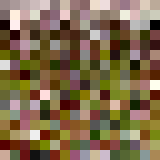

In [142]:
# 使われている色を、頻度順に並べてみる。

ind=[(x,y,z)
     for x in range(16)
     for y in range(16)
     for z in range(16)]
x=0
y=0
pal=np.zeros([160,160,3])
for xyz in sorted(ind, key=lambda x: H[0][x], reverse=True):
    if H[0][xyz] > 0:
        pal[y*10:(y+1)*10,x*10:(x+1)*10] = np.array(xyz)*255/15
        x += 1
        if x == 16:
            x=0
            y += 1
#        print(xyz, H[0][xyz])
display(PIL.Image.fromarray(pal.astype(np.uint8)))

(x,y,z)の順で対応していることがわかった。

In [ ]:
?np.histogramdd

In [ ]:
from scipy.spatial import ConvexHull
hull =  ConvexHull(fp)

In [143]:
# Distances of points from a 3D convex hull
#
# https://stackoverflow.com/questions/55460133/distance-to-convex-hull-from-point-in-3d-in-python

from PyGEL3D import gel

def dist(hull, points):
    # Construct PyGEL Manifold from the convex hull
    m = gel.Manifold()
    for s in hull.simplices:
        m.add_face(hull.points[s])

    dist = gel.MeshDistance(m)
    res = []
    for p in points:
        # Get the distance to the point
        # But don't trust its sign, because of possible
        # wrong orientation of mesh face
        d = dist.signed_distance(p)

        # Correct the sign with ray inside test
        if dist.ray_inside_test(p):
            if d > 0:
                d *= -1
        else:
            if d < 0:
                d *= -1
        res.append(d)
    return np.array(res)


In [ ]:
points = np.array([(x+0.5,y+0.5,z+0.5)
                   for x in range(16)
                   for y in range(16)
                   for z in range(16)])
points /= 16

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(dist(hull,points))

ほとんどの点がhullの外にある。

ペナルティを計算する。

* hull内の点は、一番近い点からの距離をペナルティとする。
* hull外の点は、hullまでの距離をペナルティとする。
* 両者のバランスは係数Cで調節する。

In [149]:
import random

def Penalty(fp,points,hist):
    C=250.0
    hull =  ConvexHull(fp)
    distances = dist(hull, points)
    penalty = 0.0
    insider = 0
    outsider = 0
    for d,p,w in zip(distances, points, hist):
        if w > 0.0:
            if d > 0:
                penalty += d*C*w
                outsider += 1
            else:
                Dmin = 1e99
                for v in fp:
                    D = np.linalg.norm(v-p)
                    if D < Dmin:
                        Dmin = D
                penalty += Dmin*w
                insider += 1
    return penalty, insider, outsider

def Penalty2(fp,points,hist):
    """
    Numpy style
    """
    C=250.0
    hull =  ConvexHull(fp)
    distances = dist(hull, points)
    penalty = 0.0
    insider = 0
    outsider = 0
    d = distances[hist>0]
    p = points[hist>0]
    w = hist[hist>0]
    
    outsiders = d[d>0]
    penalty = C*np.sum(outsiders*w[d>0])

    insiders = p[d<0]
    Dmins = np.array([np.min(np.linalg.norm(fp-P, axis=1))
                      for P in insiders])
    penalty += np.sum(Dmins*w[d<0])
    return penalty, insiders.shape[0], outsiders.shape[0]


def show_palette(fp):
    Ncolor = fp.shape[0]
    squares = np.zeros([20,20*Ncolor,3])
    for i in range(Ncolor):
        squares[:,i*20:(i+1)*20] = fp[i]*255
    display(PIL.Image.fromarray(squares.astype(np.uint8)))

In [146]:
P, ins, outs = Penalty(fp,points,hist)
lasti=0
for i in range(30000):
    particle = i % 8
    fp_new = fp.copy()
    fp_new[particle] += (np.random.random([3])-0.5)*0.25
    fp_new[particle] = np.clip(fp_new[particle],0.,1.)
    # print(fp_new[particle])
    P_new, ins, outs = Penalty2(fp_new, points, hist)
    if P_new < P:
        fp = fp_new
        P = P_new
        if lasti + 20 < i:
            print(i,P,ins, outs)
            show_palette(fp)
            lasti = i

26 24976948.350351945 15 431


49 19638807.412520092 17 429


70 9545518.02453237 39 407


92 5133711.356382611 61 385


114 4960818.529145744 77 369


135 4911103.269747727 85 361


156 3586551.399863364 83 363


177 3021547.28585003 115 331


209 1429451.2678147373 162 284


230 1364152.8137258838 192 254


255 1344558.440756889 190 256


278 956368.013556232 235 211


300 787452.6618594426 263 183


321 402709.6308851731 286 160


348 90442.00080178384 321 125


385 57294.73946673597 335 111


414 57202.19514003772 334 112


458 57177.09823013349 335 111


493 55690.22672746069 335 111


525 55129.97986791168 339 107


551 54778.78813985319 351 95


593 53539.202799526676 351 95


614 52777.95957642238 339 107


642 49513.29908571809 342 104


666 47249.62463554934 342 104


688 47238.554119467175 342 104


709 44499.58294634142 382 64


740 44244.464034192904 382 64


762 42360.77235964111 353 93


799 40166.201466271435 372 74


829 35324.71753160298 374 72


854 34467.42309577988 367 79


897 33785.13710607194 385 61


926 33697.08342166933 382 64


950 33121.93341409433 370 76


974 32946.46219290134 373 73


1007 32423.32639967794 371 75


1066 32029.267082415077 375 71


1105 29972.12887239943 375 71


1151 29240.497617345765 375 71


1198 29213.034123565376 378 68


1236 28685.60660696571 378 68


1279 28166.563271199062 378 68


1423 27819.893129800017 378 68


1575 27783.401597547803 378 68


1687 27581.06416515891 378 68


1759 26998.311746162817 378 68


1837 26929.533376483447 371 75


1879 26837.567538654752 371 75


2221 26708.34813278165 371 75


2334 26468.71441473205 375 71


2384 26377.233180297644 375 71


2496 26240.523351678203 375 71


2712 26139.321618713293 375 71


2991 26058.06984700103 375 71


3022 25980.67165685898 375 71


3119 25924.84459615747 375 71


3265 25849.70843217522 375 71


5142 25829.17072090797 375 71


6167 25823.43125817838 375 71


7511 25808.506442514583 375 71


7989 25740.315148001857 371 75


8017 25728.175311274506 371 75


12639 25699.999219681464 371 75


16071 25692.642179239847 371 75


16552 25550.93040993977 371 75


17391 25542.541242769432 371 75


18447 25530.93847526129 371 75


22762 25525.888546817336 371 75


26027 25474.889500722828 371 75


27842 25431.28939513505 362 84


In [147]:
def dither2(img, palettes):
    accum = np.zeros(3)
    result = np.zeros_like(img)
    for r,row in enumerate(img):
        for c,pixel in enumerate(row):
            accum += pixel
            bestpal = np.zeros(3)
            bestD   = 1e99
            for pal in palettes:
                D = accum - pal
                D = np.dot(D,D)
                if D < bestD:
                    bestD = D
                    bestpal = pal
            accum -= bestpal
            result[r,c] = bestpal
    return result

In [175]:
def dither3(img, palettes):
    accum = np.zeros(3)
    result = np.zeros_like(img)
    for r,row in enumerate(img):
        for c,pixel in enumerate(row):
            accum += pixel
            
            D = palettes - accum
            D = np.sum(D*D, axis=1)
            bestpal=np.argmin(D)
            accum -= palettes[bestpal]
            result[r,c] = palettes[bestpal]
    return result

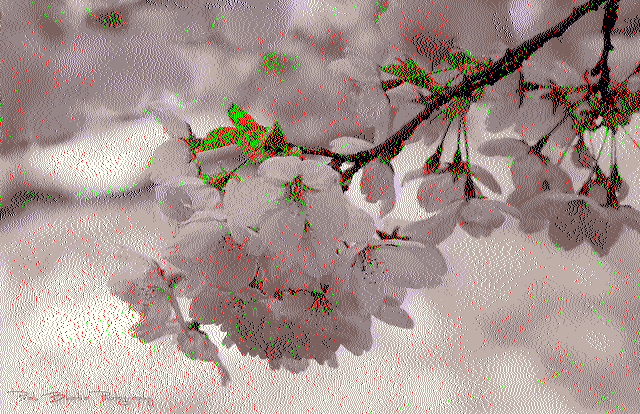

In [147]:
dithered = dither3(img, fp*255)
display(PIL.Image.fromarray(dithered.astype(np.uint8)))

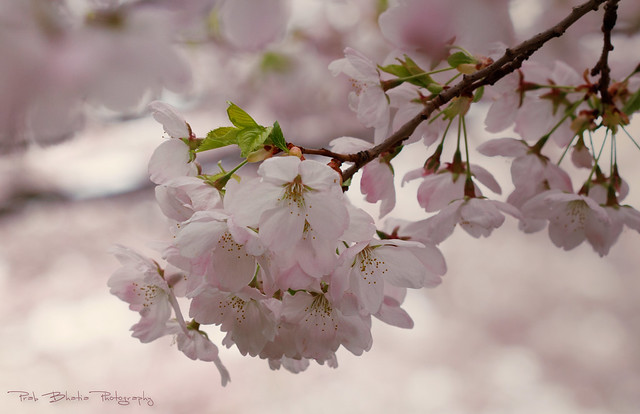

In [148]:
display(PIL.Image.fromarray(img))


In [152]:
fp_new = np.zeros([20,3])
fp_new[:8] = fp
fp = fp_new
fp.shape


(20, 3)

In [154]:
fp[8:16]=fp[:8]

In [177]:
# 16 colors

P, ins, outs = Penalty2(fp,points,hist)
lasti=0
for i in range(30000):
    Ncolor = fp.shape[0]
    particle = i % Ncolor
    fp_new = fp.copy()
    fp_new[particle] += (np.random.random([3])-0.5)*0.25
    fp_new[particle] = np.clip(fp_new[particle],0.,1.)
    # print(fp_new[particle])
    P_new, ins, outs = Penalty2(fp_new, points, hist)
    if P_new < P:
        fp = fp_new
        P = P_new
        if lasti + 20 < i:
            print(i,P,ins, outs)
            show_palette(fp)
            lasti = i

208 12851.156693359637 438 8


384 12851.14886678995 438 8


481 12806.569079710524 438 8


1172 12782.796919567001 438 8


1288 12741.340771393632 438 8


1341 12498.276521657473 438 8


1380 12335.996679476979 438 8


1448 12243.117880112575 438 8


1645 12242.309707582233 438 8


1688 12214.012600742215 438 8


1867 12193.38010907756 438 8


2718 12188.228553479683 438 8


4395 11985.65412479604 438 8


4645 11910.959191183481 438 8


4719 11883.90622257905 438 8


5061 11774.012508385867 438 8


5156 11720.758880888134 438 8


6453 11714.789290979023 438 8


7005 11617.773040647155 438 8


7383 11577.990636786715 438 8


9376 11577.938733159443 437 9


10009 11574.964799031013 430 16


11366 11574.94742850985 430 16


12047 11564.184761622677 430 16


12283 11494.827526618796 430 16


12582 11494.817314716787 430 16


13176 11355.714812290396 430 16


15506 11351.609179578789 430 16


16753 11350.889949854825 430 16


20324 11045.822212118765 430 16


22335 10975.847718587063 430 16


22537 10970.693035026845 434 12


22566 10968.771636926176 436 10


22614 10967.905174499774 437 9


22694 10967.863189197542 437 9


22790 10967.842704815721 437 9


22822 10967.783105794224 436 10


23078 10967.697807703546 436 10


24838 10967.663362112999 435 11


25318 10967.655194356113 436 10


26887 10953.083598877198 436 10


29890 10943.407012398238 436 10


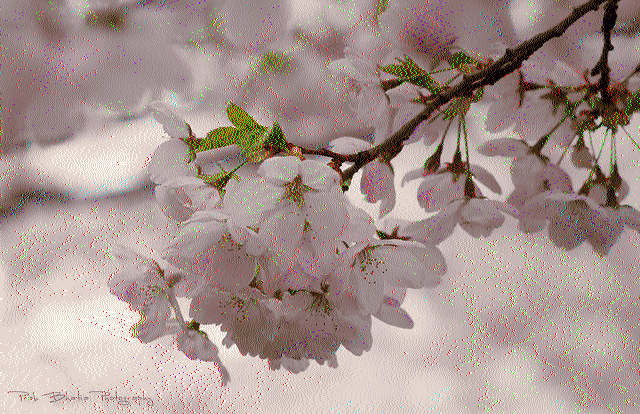

In [178]:
dithered = dither3(img, fp*255)
display(PIL.Image.fromarray(dithered.astype(np.uint8)))